# Using Sine and Cosine Transformation for Time Encoding

In [ ]:
!pip install feature_engine

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
set_style("darkgrid")

In [43]:
date_today = pd.to_datetime('today').normalize()
datetime_24_hours = pd.date_range(start=date_today, periods=24, freq='h')
df = pd.DataFrame({'dt': datetime_24_hours})
df['hour'] = df['dt'].dt.hour
df['y'] = 1

# Calculate Sin and Cosine
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)


In [44]:
df.head()

,dt,hour,y,hour_sin,hour_cos
0,2025-12-18 00:00:00,0,1,0.000000,1.000000
1,2025-12-18 01:00:00,1,1,0.258819,0.965926
2,2025-12-18 02:00:00,2,1,0.500000,0.866025
3,2025-12-18 03:00:00,3,1,0.707107,0.707107
4,2025-12-18 04:00:00,4,1,0.866025,0.500000


## Hours Linear Mode

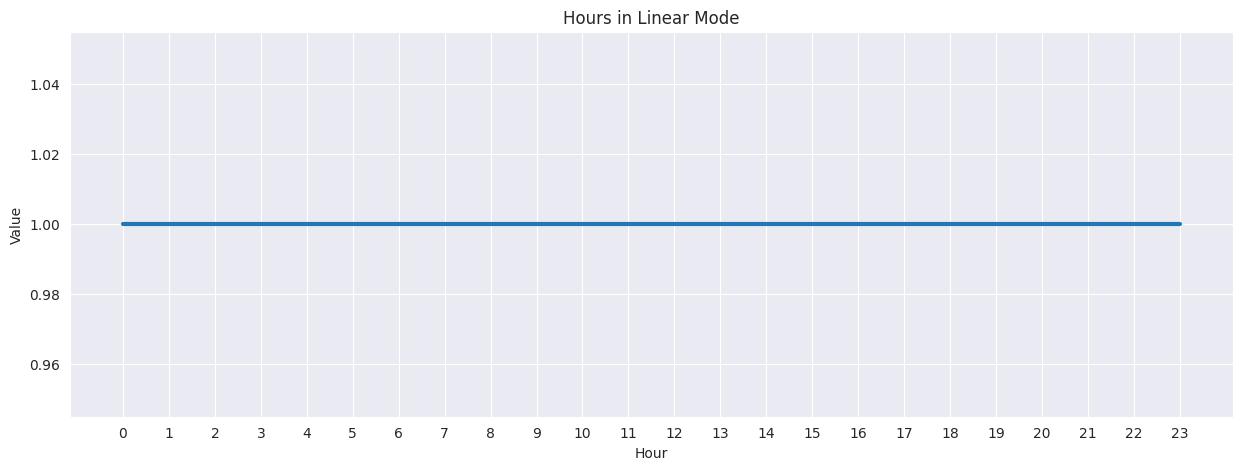

In [46]:
# Plot the Hours in Linear mode
plt.figure(figsize=(15, 5))
plt.plot(df['hour'], df['y'], linewidth=3)
plt.title('Hours in Linear Mode')
plt.xlabel('Hour')
plt.xticks(np.arange(0, 24, 1))
plt.ylabel('Value')
plt.show()

## One Hot Encoded Hours

In [49]:
from feature_engine.encoding import OneHotEncoder

In [52]:
# One Hot Encode hours
df['cat_hour'] = df['hour'].astype(str)
ohe = OneHotEncoder(variables=['cat_hour'], drop_last=True)
df = ohe.fit_transform(df)

<Axes: >

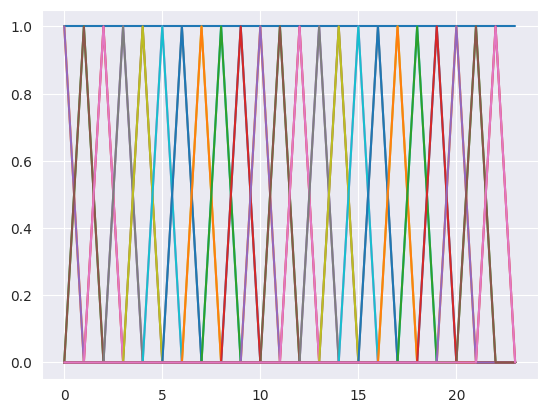

In [61]:
df.drop(['dt', 'hour', 'hour_sin', 'hour_cos'], axis=1).plot(legend=False)

## Cyclical Time

Text(0.5, 0, 'Hour')

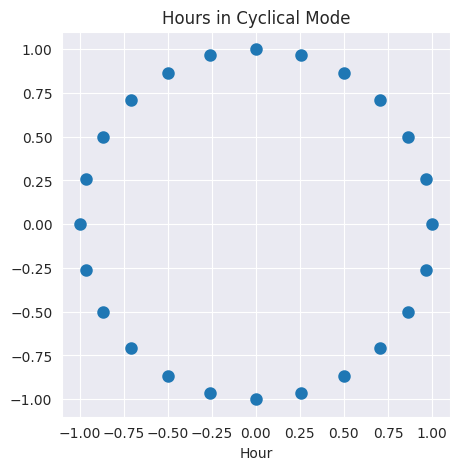

In [65]:
plt.figure(figsize=(5, 5))
plt.scatter(df['hour_sin'], df['hour_cos'], linewidth=3)
plt.title('Hours in Cyclical Mode')
plt.xlabel('Hour')

# Modeling

In [146]:
!pip install ucimlrepo --quiet

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from ucimlrepo import fetch_ucirepo

In [213]:
# fetch dataset
appliances_energy_prediction = fetch_ucirepo(id=374)

# data (as pandas dataframes)
X = appliances_energy_prediction.data.features
y = appliances_energy_prediction.data.targets

# To Pandas
df = pd.concat([X, y], axis=1)
df['date'] = df['date'].apply(lambda x: x[:10] + ' ' + x[11:])
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df.head(3)

,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances,month,day,hour
0,2016-01-11 07:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60,1,11,7
1,2016-01-11 07:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60,1,11,7
2,2016-01-11 07:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50,1,11,7


In [217]:
df.columns

Index(['date', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2', 'Appliances', 'month', 'day', 'hour',
       'hour_sin', 'hour_cos'],
      dtype='object')

### Model with Linear time

In [254]:
# X and y
X = df[['hour', 'day', 'T1', 'RH_1', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']]
y = df['Appliances']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
lr = RandomForestRegressor().fit(X_train, y_train)

# Score
print(f'Score: {lr.score(X_train, y_train)}')

Score: 0.9393642053197155


In [249]:
# Test RMSE
y_pred = lr.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse}')

RMSE: 63.60964667197874


### Model with Cyclical Time

In [243]:
# Add cyclical hours sin and cosine
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

In [255]:
# X and y
X = df[['hour_sin', 'hour_cos', 'day_sin', 'day_cos','T1', 'RH_1', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']]
y = df['Appliances']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
lr_cycle = RandomForestRegressor().fit(X_train, y_train)

# Score
print(f'Score: {lr_cycle.score(X_train, y_train)}')

Score: 0.940408544685059


In [252]:
# Test RMSE
y_pred = lr_cycle.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse}')

RMSE: 62.87008070927842
